In [69]:
import os
import pandas as pd
import matplotlib.pyplot as plt


In [70]:
# Function to parse the QREL file
def parse_qrels(qrels_file):
    qrels = {}
    with open(qrels_file, 'r') as file:
        for line in file:
            query_id, _, doc_id, relevance = line.split()
            relevance = int(relevance)
            if query_id not in qrels:
                qrels[query_id] = {}
            qrels[query_id][doc_id] = relevance
    return qrels

In [71]:
# Function to calculate precision at k
def precision_at_k(relevant, retrieved, k):
    if k > len(retrieved):
        k = len(retrieved)
    retrieved_at_k = retrieved[:k]
    true_positives = sum([1 for doc_id in retrieved_at_k if doc_id in relevant and relevant[doc_id] > 0])
    return true_positives / k

# Function to calculate Mean Average Precision (MAP) at k
def mean_average_precision_at_k(relevant, retrieved, k):
    precision_values = []
    relevant_count = 0
    for i, doc_id in enumerate(retrieved[:k]):
        if doc_id in relevant and relevant[doc_id] > 0:
            relevant_count += 1
            precision_values.append(relevant_count / (i + 1))  # Calculate precision at each relevant document rank
    if not precision_values:
        return 0.0
    return sum(precision_values) / len(precision_values)

# Function to calculate P and MAP
def calculate_metrics(df, qrel_dict):
    results = []
    grouped = df.groupby('topicId')
    
    for topic, group in grouped:
        relevant_docs = qrel_dict.get(str(topic), {})  # Ensure topic is a string
        retrieved_docs = group.sort_values('ranking')['docId'].tolist()
        
        p_at_10 = precision_at_k(relevant_docs, retrieved_docs, 10)
        p_at_50 = precision_at_k(relevant_docs, retrieved_docs, 50)
        map_at_100 = mean_average_precision_at_k(relevant_docs, retrieved_docs, 100) #MAP
        map_at_20 = mean_average_precision_at_k(relevant_docs, retrieved_docs, 20) #MAP
        
        results.append({'topicId': topic, 'P@10': p_at_10, 'P@50': p_at_50, 'MAP@100': map_at_100, 'MAP@20': map_at_20})
    
    return results

In [72]:
# Define paths
qrel_file_path = 'D:\\VSCODE PROJECT\\IR\\dataset\\qrels.trec8.csv'
input_dir = 'D:\\VSCODE PROJECT\\IR\\cleaned'  # Replace with your input files directory
output_dir = 'D:\\VSCODE PROJECT\\IR\\scores'
output_file_name = 'final_results.csv'
output_path = os.path.join(output_dir, output_file_name)


In [73]:
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Parse the QREL file
qrel_dict = parse_qrels(qrel_file_path)

# Get the list of input files
input_files = [os.path.join(input_dir, file) for file in os.listdir(input_dir) if file.endswith('.csv')]

# Initialize a DataFrame to store all results
all_results = []

# Process each input file
for file in input_files:
    try:
        # Read the input dataset
        input_df = pd.read_csv(file, delimiter=',', names=['topicId', 'identifier', 'docId', 'ranking', 'similarityScore', 'systemName'])
        
        # Calculate metrics
        results = calculate_metrics(input_df, qrel_dict)
        
        # Convert to DataFrame
        results_df = pd.DataFrame(results)
        results_df['system'] = os.path.basename(file).split('.')[0]
        
        # Append to all results
        all_results.append(results_df)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

In [74]:
# Concatenate all results into a single DataFrame
if all_results:
    final_results = pd.concat(all_results, ignore_index=True)
    # Save the final results to a file
    final_results.to_csv(output_path, index=False)
    
    # Display the final results in separate tables for P@10, P@100, AP@100, and MAP@100
    table_format_p10 = final_results.pivot(index='topicId', columns='system', values='P@10')
    table_format_p50 = final_results.pivot(index='topicId', columns='system', values='P@50')
    table_format_map100 = final_results.pivot(index='topicId', columns='system', values='MAP@100')
    table_format_map20 = final_results.pivot(index='topicId', columns='system', values='MAP@20')

else:
    print("No valid data found to concatenate.")


In [75]:

print("\nTable for P@10:")
display(table_format_p10)

# Create a figure and axis
plt.figure(figsize=(10, 4))  # Example: width = 10, height = 4
fig, ax = plt.subplots()

# Hide axes for cleaner table appearance
ax.axis('off')

# Create table and add row labels
table = ax.table(
    cellText=table_format_p10.values, 
    colLabels=table_format_p10.columns,
    rowLabels=table_format_p10.index,
    loc='center'
)

# Save the table as an image
plt.savefig(f"p@10_table.png", bbox_inches='tight', dpi=300)  # Customize filename and format
plt.close(fig)  # Close the figure to avoid memory leaks


Table for P@10:


system,Dm8Nbn,Flab8at,Flab8ax,GE8MTD2,MITSLStd,Mer8Adtd2,UB99T,apl8c221,att99ate,isa25t,mds08a2,ok8amxc,pir9Aa1,plt8ah2,ric8dpn
topicId,,,,,,,,,,,,,,,
401,0.0,0.2,0.3,1.0,0.3,0.2,0.0,0.7,0.4,0.0,0.0,0.0,0.0,0.0,0.0
402,0.6,0.6,0.9,0.6,0.7,0.6,0.0,0.8,0.6,0.0,0.5,0.6,0.6,0.5,0.5
403,0.6,0.9,1.0,1.0,0.9,0.7,0.5,1.0,0.9,0.3,0.9,1.0,0.9,0.9,0.9
404,0.1,0.2,0.3,0.4,0.4,0.4,0.1,0.4,0.2,0.0,0.0,0.6,0.6,0.3,0.2
405,0.2,0.5,0.4,0.6,0.2,0.3,0.1,0.6,0.3,0.0,0.4,0.3,0.4,0.3,0.4
406,0.2,0.5,0.5,0.4,0.4,0.4,0.0,0.6,0.5,0.0,0.3,0.6,0.4,0.4,0.5
407,0.3,0.9,1.0,0.6,0.7,0.8,0.1,0.8,0.9,0.8,0.5,0.9,0.5,0.4,0.3
408,0.1,0.3,0.4,0.7,0.4,0.4,0.0,0.3,0.2,0.6,0.4,0.6,0.5,0.5,0.4
409,0.2,0.2,0.2,0.4,0.4,0.3,0.1,0.3,0.1,0.0,0.2,0.3,0.3,0.2,0.2


<Figure size 1000x400 with 0 Axes>

In [76]:
print("\nTable for P@50:")
display(table_format_p50)

# Create a figure and axis
plt.figure(figsize=(10, 4))  # Example: width = 10, height = 4
fig, ax = plt.subplots()

# Hide axes for cleaner table appearance
ax.axis('off')

# Create table and add row labels
table = ax.table(
    cellText=table_format_p50.values, 
    colLabels=table_format_p50.columns,
    rowLabels=table_format_p50.index,
    loc='center'
)

# Save the table as an image
plt.savefig(f"p@50_table.png", bbox_inches='tight', dpi=300)  # Customize filename and format
plt.close(fig)  # Close the figure to avoid memory leaks



Table for P@50:


system,Dm8Nbn,Flab8at,Flab8ax,GE8MTD2,MITSLStd,Mer8Adtd2,UB99T,apl8c221,att99ate,isa25t,mds08a2,ok8amxc,pir9Aa1,plt8ah2,ric8dpn
topicId,,,,,,,,,,,,,,,
401,0.04,0.12,0.10,0.92,0.24,0.10,0.00,0.62,0.34,0.02,0.02,0.04,0.06,0.00,0.00
402,0.24,0.30,0.52,0.30,0.36,0.28,0.06,0.48,0.32,0.10,0.32,0.34,0.42,0.30,0.32
403,0.32,0.40,0.40,0.38,0.40,0.36,0.16,0.40,0.42,0.34,0.40,0.36,0.38,0.34,0.32
404,0.06,0.20,0.26,0.28,0.36,0.38,0.18,0.28,0.22,0.00,0.16,0.34,0.28,0.28,0.22
405,0.08,0.22,0.30,0.34,0.20,0.22,0.10,0.30,0.22,0.00,0.20,0.26,0.18,0.10,0.18
406,0.04,0.18,0.20,0.18,0.20,0.14,0.00,0.26,0.20,0.00,0.18,0.18,0.16,0.16,0.20
407,0.10,0.54,0.52,0.38,0.48,0.36,0.06,0.40,0.64,0.24,0.38,0.52,0.36,0.20,0.30
408,0.20,0.36,0.44,0.36,0.50,0.42,0.06,0.48,0.30,0.34,0.30,0.34,0.46,0.30,0.28
409,0.08,0.10,0.10,0.14,0.16,0.18,0.08,0.14,0.08,0.00,0.14,0.12,0.10,0.12,0.16


<Figure size 1000x400 with 0 Axes>

In [77]:
print("\nTable for MAP@100:")
display(table_format_map100.round(4))

table=table_format_map100.round(4)

# Create a figure and axis
plt.figure(figsize=(10, 4))  # Example: width = 10, height = 4
fig, ax = plt.subplots()

# Hide axes for cleaner table appearance
ax.axis('off')

# Create table and add row labels
table = ax.table(
    cellText=table.values, 
    colLabels=table.columns,
    rowLabels=table.index,
    loc='center'
)

# Save the table as an image
plt.savefig(f"map@100_table.png", bbox_inches='tight', dpi=300)  # Customize filename and format
plt.close(fig)  # Close the figure to avoid memory leaks


Table for MAP@100:


system,Dm8Nbn,Flab8at,Flab8ax,GE8MTD2,MITSLStd,Mer8Adtd2,UB99T,apl8c221,att99ate,isa25t,mds08a2,ok8amxc,pir9Aa1,plt8ah2,ric8dpn
topicId,,,,,,,,,,,,,,,
401,0.0384,0.1981,0.3038,0.9232,0.2955,0.2266,0.0312,0.6782,0.4075,0.0365,0.0398,0.0554,0.0770,0.0103,0.0000
402,0.3378,0.4508,0.6619,0.5059,0.5758,0.4679,0.0712,0.6503,0.5397,0.1252,0.4656,0.5376,0.4969,0.4268,0.4706
403,0.4987,0.8453,0.9082,0.9057,0.8333,0.6014,0.3463,0.8817,0.8194,0.3876,0.7910,0.8805,0.7669,0.6994,0.7913
404,0.0911,0.2086,0.3194,0.3807,0.4395,0.4053,0.1695,0.3754,0.2435,0.0000,0.2367,0.4433,0.4184,0.3134,0.2516
405,0.3198,0.4115,0.4296,0.5817,0.3055,0.2658,0.1226,0.4535,0.2961,0.0000,0.3055,0.3971,0.3830,0.3966,0.3164
406,0.8333,0.4550,0.4385,0.5060,0.5183,0.4479,0.0192,0.4733,0.5316,0.0000,0.3068,0.5071,0.4179,0.3947,0.4075
407,0.1759,0.6993,0.6646,0.5886,0.6395,0.5477,0.2092,0.5982,0.7460,0.7388,0.4990,0.6809,0.4445,0.3871,0.3508
408,0.2336,0.4193,0.4664,0.5342,0.4910,0.4201,0.0738,0.4363,0.3400,0.4226,0.3813,0.4409,0.5075,0.3880,0.3892
409,0.4770,0.2384,0.2598,0.4509,0.3497,0.3772,0.1121,0.3767,0.2354,0.0000,0.2496,0.3253,0.3766,0.2333,0.2135


<Figure size 1000x400 with 0 Axes>

In [78]:
print("\nTable for MAP@20:")
display(table_format_map20.round(4))

table=table_format_map20.round(4)

# Create a figure and axis
plt.figure(figsize=(10, 4))  # Example: width = 10, height = 4
fig, ax = plt.subplots()

# Hide axes for cleaner table appearance
ax.axis('off')

# Create table and add row labels
table = ax.table(
    cellText=table.values, 
    colLabels=table.columns,
    rowLabels=table.index,
    loc='center'
)

# Save the table as an image
plt.savefig(f"map@20_table.png", bbox_inches='tight', dpi=300)  # Customize filename and format
plt.close(fig)  # Close the figure to avoid memory leaks


Table for MAP@20:


system,Dm8Nbn,Flab8at,Flab8ax,GE8MTD2,MITSLStd,Mer8Adtd2,UB99T,apl8c221,att99ate,isa25t,mds08a2,ok8amxc,pir9Aa1,plt8ah2,ric8dpn
topicId,,,,,,,,,,,,,,,
401,0.0000,0.4625,0.5943,0.9946,0.4736,0.5033,0.0000,0.8260,0.5176,0.0000,0.0000,0.0909,0.0922,0.0000,0.0000
402,0.4961,0.8064,0.8950,0.8377,0.7843,0.7314,0.0667,0.8675,0.7326,0.1288,0.6950,0.7331,0.6602,0.6270,0.7059
403,0.6287,0.9261,1.0000,0.9963,0.8996,0.6711,0.4860,0.9679,0.8856,0.3286,0.8443,0.9828,0.8471,0.7715,0.9012
404,0.2000,0.1743,0.4691,0.5428,0.6198,0.4674,0.1383,0.6427,0.2563,0.0000,0.1249,0.5996,0.8708,0.2991,0.1662
405,0.3833,0.5277,0.6089,0.7309,0.3536,0.3365,0.1484,0.7230,0.3765,0.0000,0.3875,0.5136,0.5212,0.6247,0.4278
406,0.8333,0.6221,0.5474,0.5880,0.7227,0.5401,0.0000,0.5674,0.6673,0.0000,0.4125,0.7186,0.6422,0.5303,0.6111
407,0.3407,0.9255,0.9333,0.7766,0.7357,0.7983,1.0000,0.8487,0.9292,0.7844,0.5931,0.8805,0.5842,0.6091,0.4840
408,0.2225,0.5914,0.6126,0.8189,0.7102,0.5731,0.0588,0.4319,0.3836,0.5678,0.6118,0.6876,0.7296,0.6338,0.6924
409,0.6082,0.4338,0.4609,0.8526,0.4594,0.5360,0.1111,0.7784,0.5588,0.0000,0.4024,0.7778,0.7019,0.4909,0.3139


<Figure size 1000x400 with 0 Axes>

In [79]:
import os
import pandas as pd

# Path to the final results CSV file
output_path = r'D:\VSCODE PROJECT\IR\scores\final_results.csv'

# Load the final results DataFrame
final_results = pd.read_csv(output_path)

# Compute average scores for each system
average_scores = final_results.groupby('system').mean().reset_index()

# Select relevant columns for output
average_scores = average_scores[['system', 'P@10', 'MAP@100']]

# Sort the average scores in ascending order
average_scores = average_scores.sort_values(by=['P@10', 'MAP@100'], ascending=False).reset_index(drop=True)

# Print the average scores for each system in a table
print("Average Precision@10 and MAP@100 for each system:")
display(average_scores)

# Ensure the output directory exists
output_directory = r'D:\VSCODE PROJECT\IR\scores'
os.makedirs(output_directory, exist_ok=True)

# Save the average scores to a CSV file
average_scores.to_csv(os.path.join(output_directory, 'average_scores.csv'), index=False)

# Output in a readable format
for _, row in average_scores.iterrows():
    print(f"System {row['system']}:")
    print(f"  Average Precision@10: {row['P@10']:.4f}")
    print(f"  Average MAP@100: {row['MAP@100']:.4f}")


Average Precision@10 and MAP@100 for each system:


,system,P@10,MAP@100
0,GE8MTD2,0.602,0.562747
1,ok8amxc,0.550,0.503462
2,Flab8ax,0.524,0.490554
3,MITSLStd,0.508,0.490214
4,apl8c221,0.504,0.467786
5,Flab8at,0.486,0.467668
6,att99ate,0.476,0.439029
7,ric8dpn,0.450,0.430575
8,pir9Aa1,0.450,0.427635
9,Mer8Adtd2,0.444,0.423007


System GE8MTD2:
  Average Precision@10: 0.6020
  Average MAP@100: 0.5627
System ok8amxc:
  Average Precision@10: 0.5500
  Average MAP@100: 0.5035
System Flab8ax:
  Average Precision@10: 0.5240
  Average MAP@100: 0.4906
System MITSLStd:
  Average Precision@10: 0.5080
  Average MAP@100: 0.4902
System apl8c221:
  Average Precision@10: 0.5040
  Average MAP@100: 0.4678
System Flab8at:
  Average Precision@10: 0.4860
  Average MAP@100: 0.4677
System att99ate:
  Average Precision@10: 0.4760
  Average MAP@100: 0.4390
System ric8dpn:
  Average Precision@10: 0.4500
  Average MAP@100: 0.4306
System pir9Aa1:
  Average Precision@10: 0.4500
  Average MAP@100: 0.4276
System Mer8Adtd2:
  Average Precision@10: 0.4440
  Average MAP@100: 0.4230
System mds08a2:
  Average Precision@10: 0.4160
  Average MAP@100: 0.3949
System plt8ah2:
  Average Precision@10: 0.3320
  Average MAP@100: 0.3278
System Dm8Nbn:
  Average Precision@10: 0.1900
  Average MAP@100: 0.2271
System UB99T:
  Average Precision@10: 0.1460
  

In [80]:
import pandas as pd

# Data
data = final_results

# Create DataFrame
df = pd.DataFrame(data)

# Compute Pearson, Spearman correlation coefficients
correlations = pd.DataFrame(index=['Pearson', 'Spearman'], columns=['P@10 vs P@50', 'P@10 vs MAP@20', 'P@10 vs MAP@100', 'P@50 vs MAP@20', 'P@50 vs MAP@100', 'MAP@100 vs MAP@20'])

metrics = ['P@10', 'P@50', 'MAP@100', 'MAP@20']
for i, metric1 in enumerate(metrics):
    for metric2 in metrics[i+1:]:
        pearson_corr = df[[metric1, metric2]].corr(method='pearson').iloc[0, 1]
        spearman_corr = df[[metric1, metric2]].corr(method='spearman').iloc[0, 1]
        
        correlations.loc['Pearson', f'{metric1} vs {metric2}'] = pearson_corr
        correlations.loc['Spearman', f'{metric1} vs {metric2}'] = spearman_corr

print("Correlation Coefficients:")
display(correlations)



Correlation Coefficients:


,P@10 vs P@50,P@10 vs MAP@20,P@10 vs MAP@100,P@50 vs MAP@20,P@50 vs MAP@100,MAP@100 vs MAP@20
Pearson,0.824226,0.9067,0.934751,0.725128,0.813456,0.930644
Spearman,0.865256,0.917755,0.940229,0.769468,0.845717,0.936703


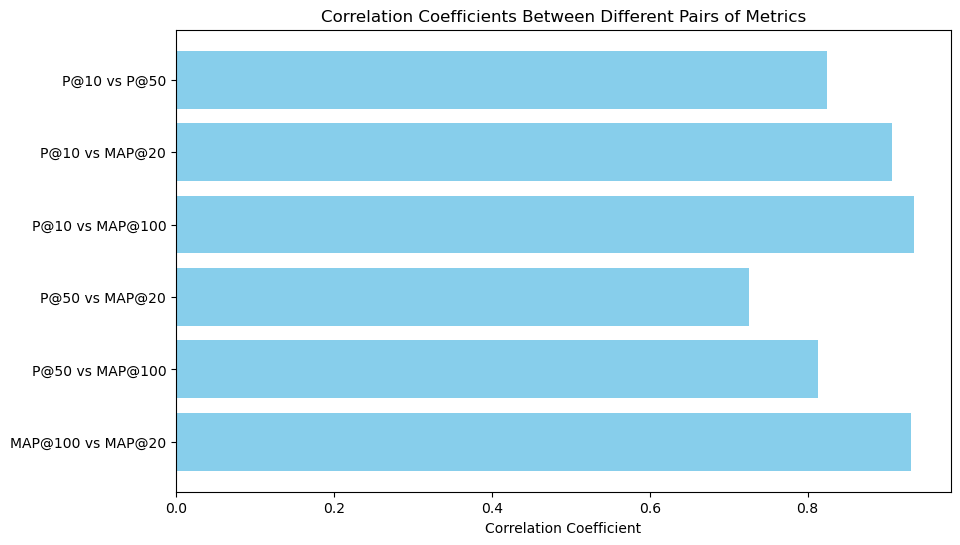

In [81]:
import matplotlib.pyplot as plt

# Your correlation coefficients
correlation_data = {
    'P@10 vs P@50': 0.824226,
    'P@10 vs MAP@20': 0.9067,
    'P@10 vs MAP@100': 0.934751,
    'P@50 vs MAP@20': 0.725128,
    'P@50 vs MAP@100': 0.813456,
    'MAP@100 vs MAP@20': 0.930644
}

# Convert the correlation data into lists
pairs = list(correlation_data.keys())
coefficients = list(correlation_data.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.barh(pairs, coefficients, color='skyblue')
plt.xlabel('Correlation Coefficient')
plt.title('Correlation Coefficients Between Different Pairs of Metrics')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest correlation at the top
plt.show()
